In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()


import shapely
import shapely.vectorized

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import geopy
import geopy.distance
import geopandas

import cartopy.io.shapereader as shpreader


import pandas as pd

In [2]:
df = pd.read_csv('data/doc_information.csv')
df.head()

,id,title,content,PY,wc__oecd,wosarticle__di,DOI,continent
0,3255833,Assessment of spatiotemporal variability of re...,Reference evapotranspiration (ETo) is a key co...,2019.0,NaN,10.1016/j.agwat.2018.09.037,[10.1016/j.agwat.2018.09.037](https://dx.doi.o...,Asia
1,702492,The Importance of Bank Vole Density and Rainy ...,"Pathogenic hantaviruses (family Bunyaviridae, ...",2014.0,Natural Sciences,10.1371/journal.pone.0111663,[10.1371/journal.pone.0111663](https://dx.doi....,Europe
2,14865,Summertime Acute Heat Illness in U.S. Emergenc...,BACKGROUND: Patients with acute heat illness p...,2014.0,Natural Sciences,10.1289/ehp.1306796,[10.1289/ehp.1306796](https://dx.doi.org/10.12...,NaN
3,3457216,Health-Related Quality of Life of Chinese Eart...,As one of the most destructive natural disaste...,2014.0,NaN,10.1007/s11205-013-0525-2,[10.1007/s11205-013-0525-2](https://dx.doi.org...,Asia
4,282602,Health coping strategies of the people vulnera...,Background: Among the many challenges faced by...,2013.0,Medical and Health Sciences,10.1186/1471-2458-13-565,[10.1186/1471-2458-13-565](https://dx.doi.org/...,Asia


In [3]:
geos = pd.read_csv('data/geo_df.csv')
geos = geos.drop_duplicates(["doc_id","word"])

geos = geos[geos['country_conf']>0.85]

geos.lat = geos.lat.astype(float)
geos.lon = geos.lon.astype(float)

geos = geos[geos['word']!="South Japan"]

geos.loc[geos["word"]=="Pakistan","feature_code"]="PCLI"
geos.loc[geos["word"]=="Colombia","feature_code"]="PCLI"
geos.loc[geos["word"]=="Argentina","feature_code"]="PCLI"

import pycountry_convert as pc
def get_cont(x):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))
    except:
        return None
geos['continent'] = geos.apply(lambda x: get_cont(x), axis=1)

geos.head()

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent
0,Shandong,36.66833,116.99722,CHN,1805753,Jinan,P,PPLA,1061,Jinan,CHN,0.999811,AS
2,NaN,35.00000,105.00000,CHN,1814991,People’s Republic of China,A,PCLI,1061,China,CHN,0.999764,AS
5,Manicaland,-19.00000,32.41667,ZWE,887358,Manicaland Province,A,ADM1,5923,Manicaland,ZWE,0.937507,AF
6,Mashonaland East,-17.96667,31.66667,ZWE,886842,Mashonaland East Province,A,ADM1,5923,Mashonaland,ZWE,0.937507,AF
7,NaN,39.69450,-8.13057,PRT,2264397,Portuguese Republic,A,PCLI,7057,Portugal,PRT,0.999579,EU


In [4]:
geos[geos['word']=="South Japan"]

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent


In [5]:
geos[geos['doc_id']==1316622]

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent
8389,NaN,35.68536,139.75309,JPN,1861060,Japan,A,PCLI,1316622,Japan,JPN,0.999997,AS
8392,Kumamoto,32.42944,130.99099,JPN,1857892,Kyushu,T,ISL,1316622,Kyushu,JPN,0.999872,AS


In [6]:
df_places = pd.merge(df.drop('continent',axis=1),geos,left_on="id",right_on="doc_id")
df_places.head()

print(df_places.shape)

geos.to_csv('../DIFID/data/locations.csv',index=False)

df_places.head()

(16847, 20)


,id,title,content,PY,wc__oecd,wosarticle__di,DOI,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent
0,3255833,Assessment of spatiotemporal variability of re...,Reference evapotranspiration (ETo) is a key co...,2019.0,NaN,10.1016/j.agwat.2018.09.037,[10.1016/j.agwat.2018.09.037](https://dx.doi.o...,NaN,35.00000,105.00000,CHN,1814991,People’s Republic of China,A,PCLI,3255833,China,CHN,1.000000,AS
1,3255833,Assessment of spatiotemporal variability of re...,Reference evapotranspiration (ETo) is a key co...,2019.0,NaN,10.1016/j.agwat.2018.09.037,[10.1016/j.agwat.2018.09.037](https://dx.doi.o...,NaN,34.00000,116.00000,CHN,1807463,Huanghuai Pingyuan,T,PLN,3255833,North China,CHN,0.999492,AS
2,702492,The Importance of Bank Vole Density and Rainy ...,"Pathogenic hantaviruses (family Bunyaviridae, ...",2014.0,Natural Sciences,10.1371/journal.pone.0111663,[10.1371/journal.pone.0111663](https://dx.doi....,Southern Savonia,61.52728,28.17495,FIN,640504,Puumala,P,PPLA3,702492,Puumala,FIN,0.983592,EU
3,702492,The Importance of Bank Vole Density and Rainy ...,"Pathogenic hantaviruses (family Bunyaviridae, ...",2014.0,Natural Sciences,10.1371/journal.pone.0111663,[10.1371/journal.pone.0111663](https://dx.doi....,NaN,62.00000,15.00000,SWE,2661886,Kingdom of Sweden,A,PCLI,702492,Sweden,SWE,0.999981,EU
4,3457216,Health-Related Quality of Life of Chinese Eart...,As one of the most destructive natural disaste...,2014.0,NaN,10.1007/s11205-013-0525-2,[10.1007/s11205-013-0525-2](https://dx.doi.org...,Sichuan,30.50000,102.66667,CHN,1794299,Sichuan Sheng,A,ADM1,3457216,Sichuan,CHN,0.997501,AS


In [7]:

def new_haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1[:,None]

    dlat = lat2 - lat1[:,None]

    a = np.sin(dlat/2.0)**2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def density_grid(degrees,distance,df):
    
    df_countries = df[df["feature_code"]=="PCLI"]
    df_places = df[df["feature_code"]!="PCLI"]

    distance = 100

    latbins = np.linspace(-90,90, round(180/degrees))
    lonbins = np.linspace(-180,180, round(360/degrees))

    n = np.zeros((len(latbins),len(lonbins)))
    
    print(f"calculating density grid of size: {n.size}")

    for i,lat in enumerate(latbins):
        r = geopy.distance.distance(kilometers=distance)
        latp = geopy.Point((lat,135))
        # if the latitude is closer than distance to the north pole, then the northern bound should be 
        # the north pole, not distancekm north of the latitude (which will pass the pole and go south again)
        if geopy.distance.great_circle(latp,(90,135)).km < distance:
            r_nbound = 90   
        else:
            r_nbound = r.destination(point=latp,bearing=0).latitude
        # Same as above for the south pole
        if geopy.distance.great_circle(latp,(-90,135)).km < distance:
            r_sbound = -90   
        else:
            r_sbound = r.destination(point=latp,bearing=180).latitude        

        latbound_df = df_places[
            (df_places.lat>=r_sbound) &
            (df_places.lat<=r_nbound)        
        ]

        ds = new_haversine_np(latbound_df['lon'], latbound_df['lat'],lonbins,[lat]*len(lonbins))

        n[i,:] = np.where(ds<distance,1,0).sum(axis=0)
        
    print("done")
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    yv, xv = np.meshgrid(latbins, lonbins)

    for country in reader.records():
        incountry = shapely.vectorized.contains(country.geometry,xv,yv)
        idx = np.argwhere(incountry==True)
        ndots = idx.size/2
        cdf = df_countries[df_countries["country_predicted"]==country.attributes["SU_A3"]]
        for point in idx:
            n[point[1],point[0]] += cdf.shape[0]/ndots


        
    return latbins, lonbins, n

latbins, lonbins, n = density_grid(0.5,100,df_places)

calculating density grid of size: 259200
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:333: UserWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  warnings.warn("The outline_patch property is deprecated. Use "
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


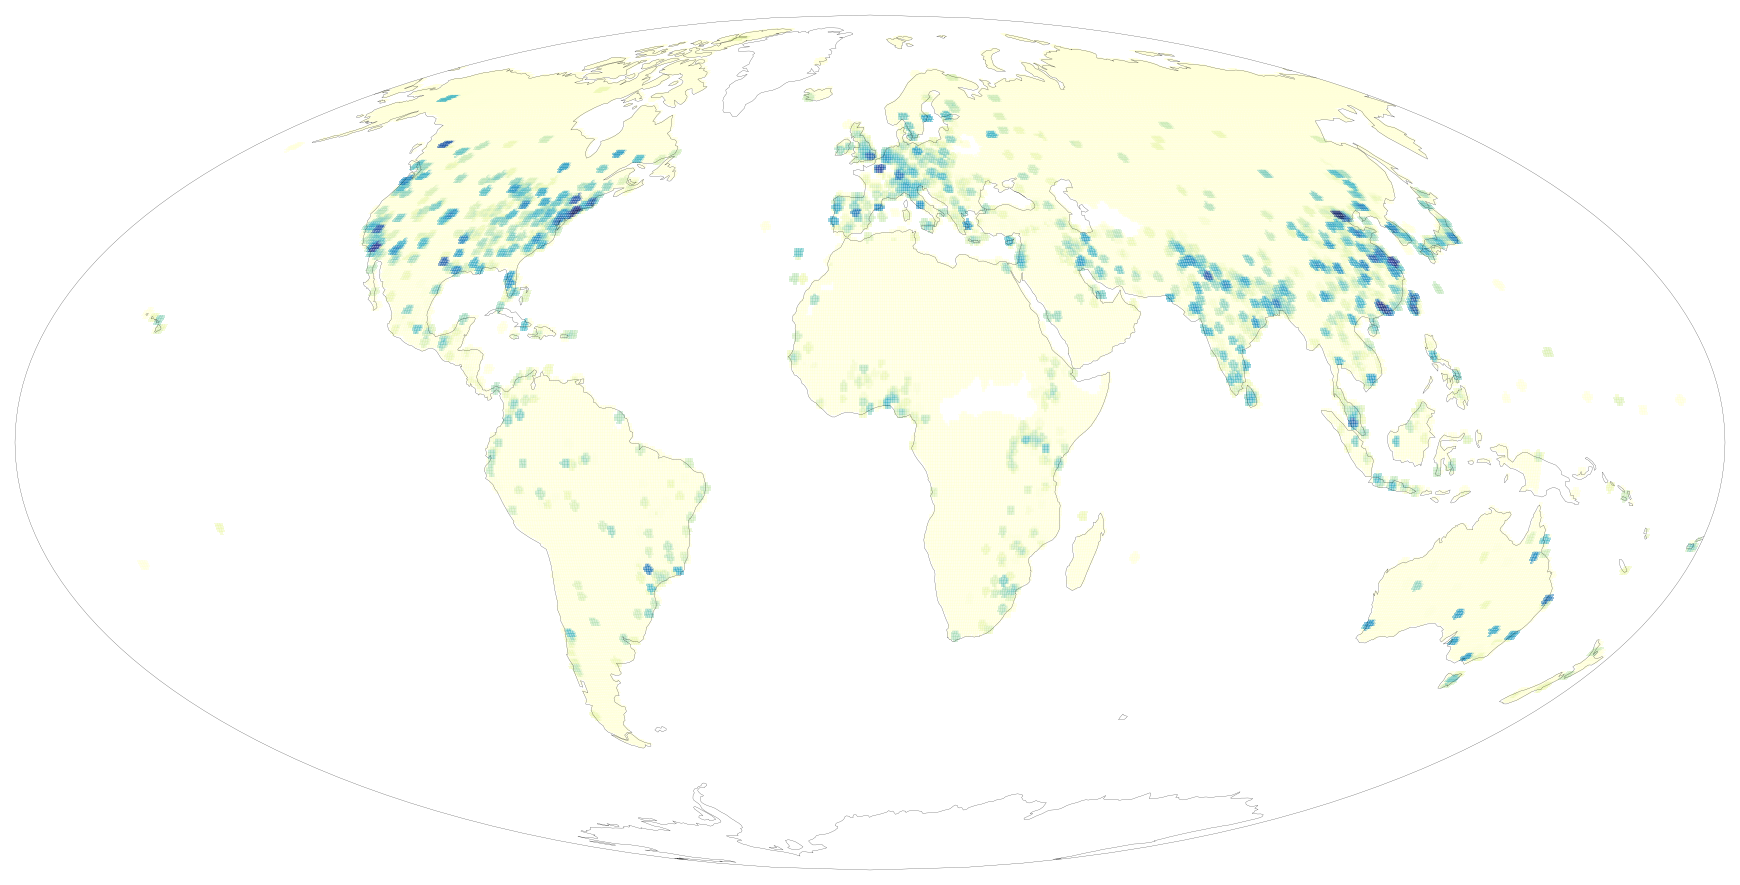

In [8]:
fig, ax = plt.subplots(dpi=150, figsize=(12,6))

p = ccrs.Mollweide()
#p = ccrs.PlateCarree()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

ax.outline_patch.set_linewidth(0.1)

#cbar = fig.colorbar(pcm)
#cbar.set_label("\# mentioned places within 100 km")

fig.tight_layout()

plt.savefig(f'plots/predicted_places_all_density.png',dpi=125)
plt.savefig(f'../dash-dfid/assets/predicted_places_all_density.png',dpi=250,bbox_inches="tight")
plt.savefig(f'plots/predicted_places_all_density.pdf')

In [9]:
dts = pd.read_csv('data/doctopic.csv')

In [47]:
dt_sum = pd.DataFrame(
    dts.groupby('topic_id')['score']
    .sum()
).reset_index().rename(columns={"score":"total_score"})
dt_sum['total_share'] = dt_sum['total_score'] / dt_sum ['total_score'].sum()
dt_sum.to_csv('../dash-dfid/data/dt_sum.csv', index=False)
dt_sum

,topic_id,total_score,total_share
0,212272,99.980951,0.020411
1,212273,151.056507,0.030837
2,212274,104.862337,0.021407
3,212275,58.549333,0.011953
4,212276,54.001191,0.011024
...,...,...,...
65,212337,83.075768,0.016960
66,212338,58.116069,0.011864
67,212339,83.187600,0.016982
68,212340,26.259997,0.005361


In [11]:
topic_info = pd.read_csv('data/topic_info.csv')
topic_info.head()

,id,title,top_words,short_title
0,212274,"Infection, Infectious disease","['diseas', 'infecti', 'respiratori', 'cardiova...",Infection
1,212321,"Mental, Mental health","['mental', 'health', 'disord', 'physic', 'psyc...",Mental
2,212322,"Drought, Drought","['drought', 'impact', 'index', 'veget', 'sever...",Drought
3,212323,"Suicide, Suicide","['suicid', 'associ', 'rate', 'attempt', 'male'...",Suicide
4,212327,"Daily, Daily data & trends","['day', 'daili', 'period', 'dure', 'visit', 'n...",Daily


In [12]:
continent_rep = []


def get_group_topics(name, group, dts, nlabs=5):
    gdt = dts[dts['doc_id'].isin(group.id)]
    gdt = pd.DataFrame(gdt.groupby('topic_id')['score'].aggregate("sum")).reset_index()
    gdt['continent'] = name
    gdt['share'] = gdt['score'] / gdt['score'].sum()    
    
    gdt = gdt.merge(dt_sum)
    gdt['deviation'] = gdt['share'] / gdt['total_share']
    
    top_topics = gdt.sort_values('deviation').tail(nlabs).merge(topic_info,left_on="topic_id",right_on="id")
    bottom_topics = gdt.sort_values('deviation').head(nlabs).merge(topic_info,left_on="topic_id",right_on="id")    
    
    return {
        "name": name,
        "common_topics": [x.split(',')[0] for x in top_topics.title],
        "common_topics_scores": top_topics.deviation,
        "uncommon_topics": [x.split(',')[0] for x in bottom_topics.title],
        "uncommon_topics_scores": bottom_topics.deviation
    }


for name, group in df_places.groupby('continent'):
    continent_rep.append(get_group_topics(name, group, dts))
    


In [13]:
country_conv = pd.read_csv("data/CountryMappingTable.csv")
country_conv.head()

,Country,Alpha-2,Alpha-3,Numeric code,Latitude (average),Longitude (average),UN continental,UN statistical,Population_2018,Population_2019,Annex I or II,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Afghanistan,AF,AFG,4,33.0000,65.0,Asia,Southern Asia,"37,171,921","38,041,754",Non-Annex I,,1,Low,NaN,NaN,NaN,NaN,NaN
1,Albania,AL,ALB,8,41.0000,20.0,Europe,Southern Europe,"2,882,740","2,880,917",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZ,DZA,12,28.0000,3.0,Africa,Northern Africa,"42,228,408","43,053,054",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
3,American Samoa,AS,ASM,16,-14.3333,-170.0,Oceania,Polynesia,"55,465","55,312",Non-Annex I,Pacific,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
4,Andorra,AD,AND,20,42.5000,1.6,Europe,Southern Europe,"77,006","77,142",Non-Annex I,NaN,0,High,NaN,NaN,NaN,NaN,NaN


In [14]:
if "ADMIN" not in df_places.columns:
    df_places = df_places.merge(country_conv,left_on="country_predicted",right_on="Alpha-3")

In [15]:
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')

country_shapes = geopandas.read_file(shpfilename).merge(country_conv,left_on="ADM0_A3",right_on="Alpha-3")
country_shapes.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,Population_2019,Annex I or II,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,"14,645,468",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,"17,861,030",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,"29,161,922",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,Vietnam,VNM,...,"96,462,106",Non-Annex I,NaN,0,Lower-middle,NaN,NaN,NaN,NaN,NaN
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,Venezuela,VEN,...,"28,515,829",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


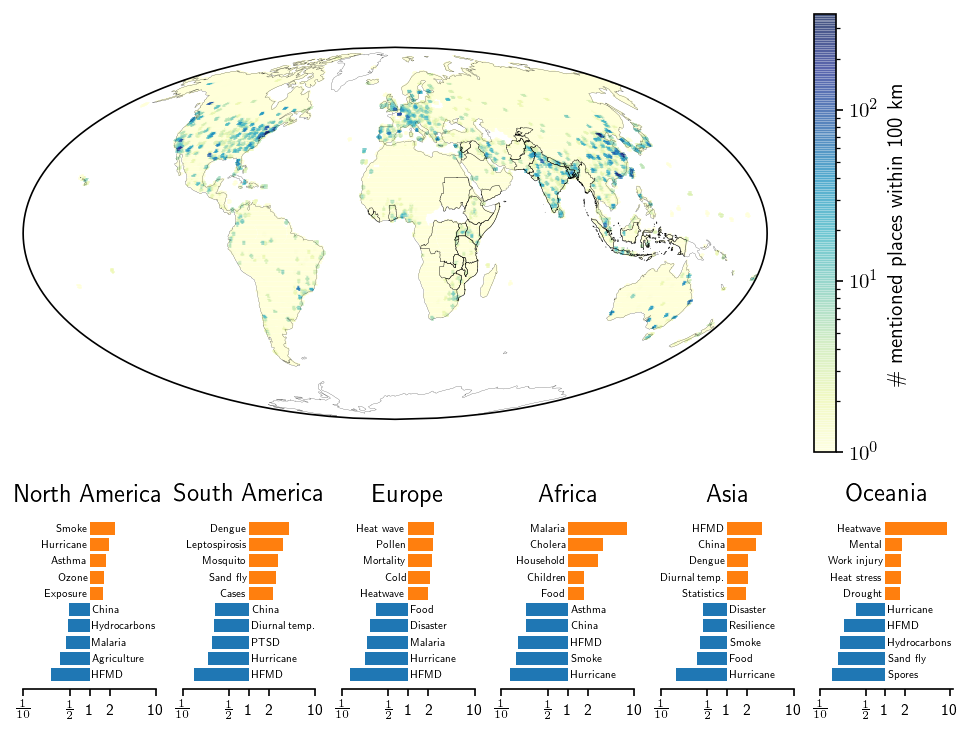

In [16]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)


fig = plt.figure(dpi=150,figsize=(8,5))
gs = gridspec.GridSpec(2, len(continent_rep), height_ratios=[1, .4,], bottom=.05, top=.95, wspace=.2)
ax1 = plt.subplot(gs[0, :], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

poly = country_shapes.loc[country_shapes['DFID priority'] == 1]['geometry'].values

ax1.add_geometries(
    poly, 
    crs=ccrs.PlateCarree(), 
    facecolor='none', 
    edgecolor='black',
    lw=0.2
)

cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 100 km")

pad = 0.1

xlab_positions = [.1,.5,1,2,10]
xlabels = [r"$\frac{1}{10}$",r"$\frac{1}{2}$",1,2,10]

ax_order = [3,4,2,0,5,1]

continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Oceania',
    'AF': 'Africa',
    'EU': 'Europe'
}

for i, cr in enumerate(continent_rep):
    ax = plt.subplot(gs[1,ax_order[i]])
    l = len(cr["common_topics_scores"])
    ax.set_title(continents[cr["name"]])
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


continent_df = pd.DataFrame



fig.tight_layout()

In [17]:
income = []
nlabs = 5

for name, group in df_places.groupby('Income'):
    income.append(get_group_topics(name, group, dts))
    
name = "DFID priority"
group = df_places[df_places["DFID priority"]==1]
income.append(get_group_topics(name, group, dts))

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


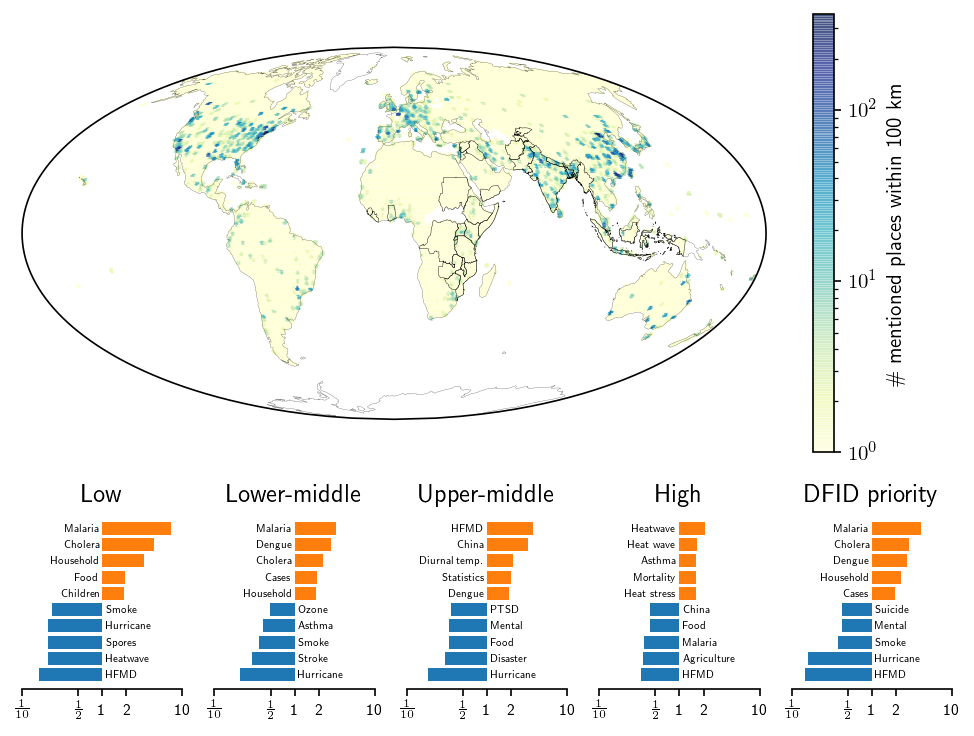

In [18]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
import geopandas
rc('text', usetex=True)

fig = plt.figure(dpi=150,figsize=(8,5))
gs = gridspec.GridSpec(2, len(income), height_ratios=[1, .4,], bottom=.05, top=.95, wspace=.2)
ax1 = plt.subplot(gs[0, :], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)




# read the german borders
poly = country_shapes.loc[country_shapes['DFID priority'] == 1]['geometry'].values

ax1.add_geometries(
    poly, 
    crs=ccrs.PlateCarree(), 
    facecolor='none', 
    edgecolor='black',
    lw=0.2
)



cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 100 km")

pad = 0.1

xlab_positions = [.1,.5,1,2,10]
xlabels = [r"$\frac{1}{10}$",r"$\frac{1}{2}$",1,2,10]

ax_order = [3,0,1,2,4]


for i, cr in enumerate(income):
    ax = plt.subplot(gs[1,ax_order[i]])
    l = len(cr["common_topics_scores"])
    ax.set_title(cr["name"])
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


continent_df = pd.DataFrame



fig.tight_layout()

In [19]:
country_conv.head()

,Country,Alpha-2,Alpha-3,Numeric code,Latitude (average),Longitude (average),UN continental,UN statistical,Population_2018,Population_2019,Annex I or II,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Afghanistan,AF,AFG,4,33.0000,65.0,Asia,Southern Asia,"37,171,921","38,041,754",Non-Annex I,,1,Low,NaN,NaN,NaN,NaN,NaN
1,Albania,AL,ALB,8,41.0000,20.0,Europe,Southern Europe,"2,882,740","2,880,917",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZ,DZA,12,28.0000,3.0,Africa,Northern Africa,"42,228,408","43,053,054",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
3,American Samoa,AS,ASM,16,-14.3333,-170.0,Oceania,Polynesia,"55,465","55,312",Non-Annex I,Pacific,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
4,Andorra,AD,AND,20,42.5000,1.6,Europe,Southern Europe,"77,006","77,142",Non-Annex I,NaN,0,High,NaN,NaN,NaN,NaN,NaN


In [20]:
un_stat = []
nlabs = 5

for name, group in df_places.groupby('UN statistical'):
    un_stat.append(get_group_topics(name, group, dts))
    
name = "DFID priority"
group = df_places[df_places["DFID priority"]==1]
un_stat.append(get_group_topics(name, group, dts))
    
len(un_stat)

23

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


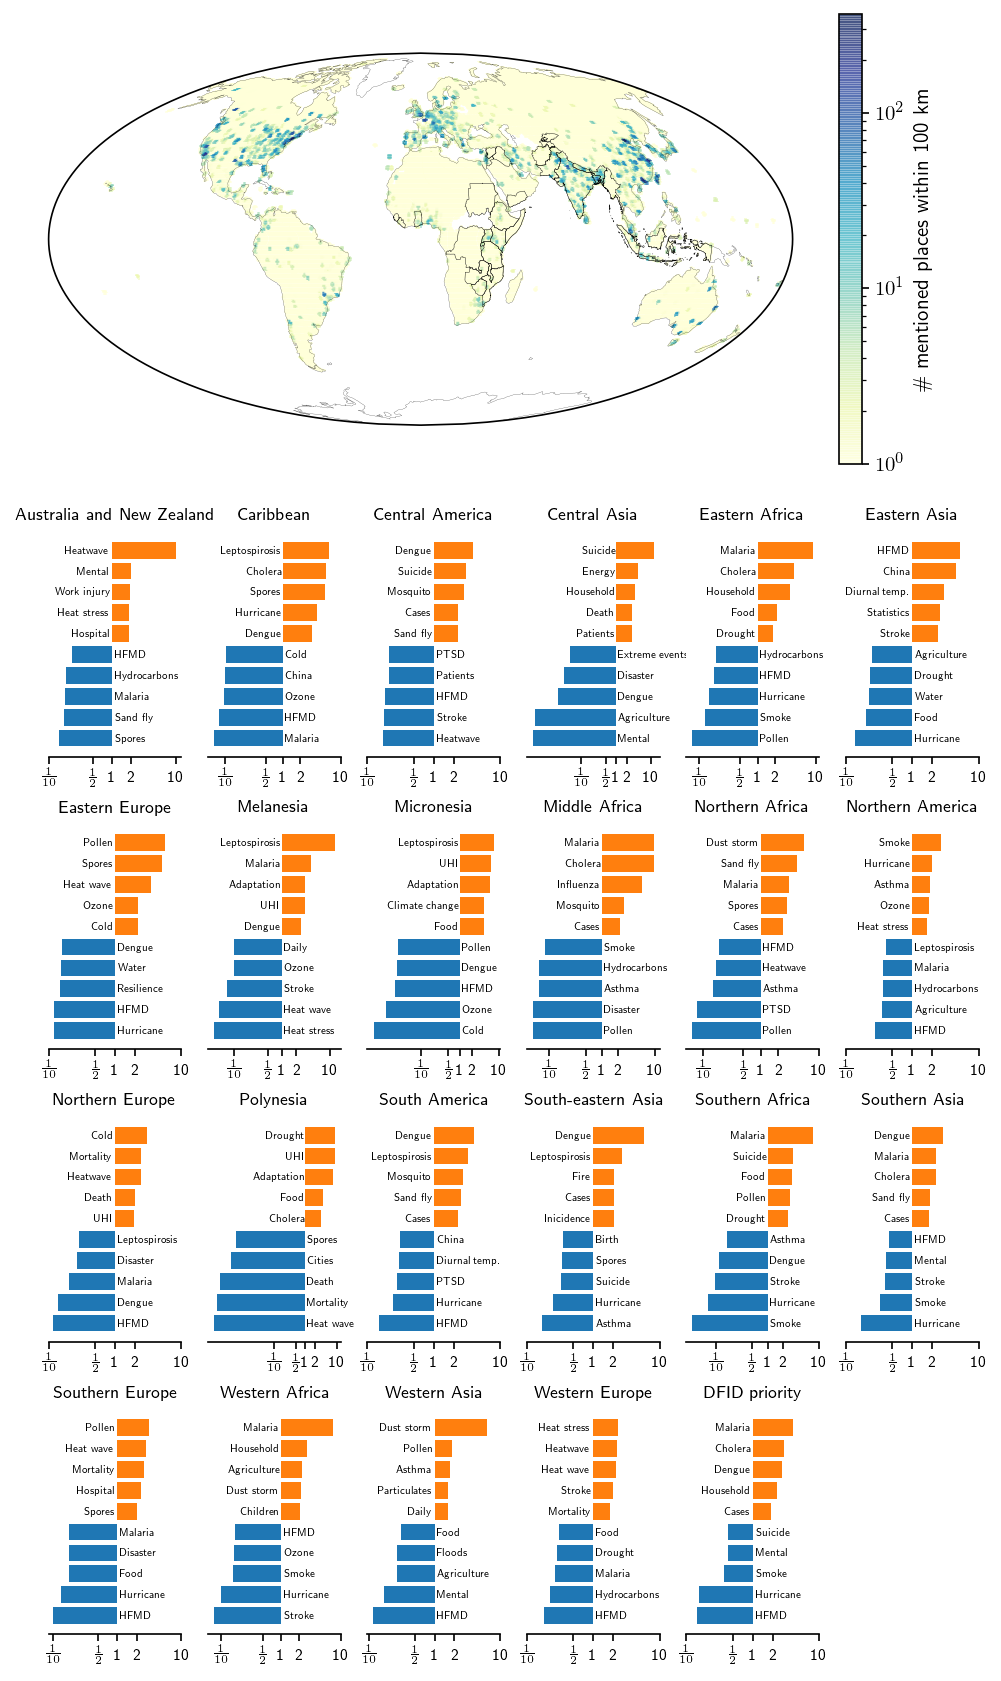

In [21]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
import geopandas
rc('text', usetex=True)

fig = plt.figure(dpi=150,figsize=(8,12))
gs = gridspec.GridSpec(5, 6, height_ratios=[.6, .3, .3, .3, .3], bottom=.05, top=.95, wspace=.2, hspace=.25)
ax1 = plt.subplot(gs[0, :], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)




# read the german borders
poly = country_shapes.loc[country_shapes['DFID priority'] == 1]['geometry'].values

ax1.add_geometries(
    poly, 
    crs=ccrs.PlateCarree(), 
    facecolor='none', 
    edgecolor='black',
    lw=0.2
)



cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 100 km")

pad = 0.1

xlab_positions = [.1,.5,1,2,10]
xlabels = [r"$\frac{1}{10}$",r"$\frac{1}{2}$",1,2,10]


for i, cr in enumerate(un_stat):
    
    ax = plt.subplot(gs[1+i//6,i%6])
    l = len(cr["common_topics_scores"])
    ax.set_title(cr["name"],fontsize=8)
    ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(range(l,l*2),np.log(cr["common_topics_scores"]))
    for j, lab in enumerate(cr["uncommon_topics"]):
        ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0-pad,j+l, lab, ha="right", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    #ax.set_yticklabels(cr["uncommon_topics"] + cr["common_topics"],fontsize=6)


continent_df = pd.DataFrame



fig.tight_layout()

In [22]:
geos[geos["word"]=="Pakistan"]

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent
449,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,60993,Pakistan,PAK,0.999923,AS
512,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,69497,Pakistan,PAK,1.000000,AS
643,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,83524,Pakistan,PAK,0.999764,AS
881,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,121917,Pakistan,PAK,0.999764,AS
1684,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,256692,Pakistan,PAK,0.999923,AS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28781,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,3727894,Pakistan,PAK,0.999923,AS
29061,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,3733288,Pakistan,PAK,0.999981,AS
29562,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,3743248,Pakistan,PAK,0.999764,AS
30075,Punjab,31.4706,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,PCLI,3752958,Pakistan,PAK,0.999764,AS


calculating density grid of size: 139230
done


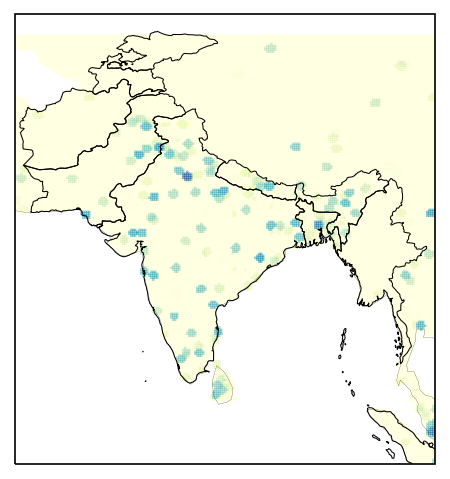

In [23]:
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import rc
import geopandas
rc('text', usetex=True)



def new_haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1[:,None]

    dlat = lat2 - lat1[:,None]

    a = np.sin(dlat/2.0)**2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def density_grid(degrees,distance,df, extent=None, include_countries=None):
    
    df_countries = df[df["feature_code"]=="PCLI"]
    df_places = df[df["feature_code"]!="PCLI"]


    latbins = np.linspace(-90,90, round(180/degrees))   
    lonbins = np.linspace(-180,180, round(360/degrees))
    
    if extent is not None:      
        lonbins = lonbins[(lonbins>=extent[0]) & (lonbins<=extent[1])]
        latbins = latbins[(latbins>=latbins[2]) & (latbins<=extent[3])]

    n = np.zeros((len(latbins),len(lonbins)))
    
    print(f"calculating density grid of size: {n.size}")

    for i,lat in enumerate(latbins):
        r = geopy.distance.distance(kilometers=distance)
        latp = geopy.Point((lat,135))
        # if the latitude is closer than distance to the north pole, then the northern bound should be 
        # the north pole, not distancekm north of the latitude (which will pass the pole and go south again)
        if geopy.distance.great_circle(latp,(90,135)).km < distance:
            r_nbound = 90   
        else:
            r_nbound = r.destination(point=latp,bearing=0).latitude
        # Same as above for the south pole
        if geopy.distance.great_circle(latp,(-90,135)).km < distance:
            r_sbound = -90   
        else:
            r_sbound = r.destination(point=latp,bearing=180).latitude        

        latbound_df = df_places[
            (df_places.lat>=r_sbound) &
            (df_places.lat<=r_nbound)        
        ]

        ds = new_haversine_np(latbound_df['lon'], latbound_df['lat'],lonbins,[lat]*len(lonbins))

        n[i,:] = np.where(ds<distance,1,0).sum(axis=0)
        
    print("done")
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    yv, xv = np.meshgrid(latbins, lonbins)

    for country in reader.records():
        incountry = shapely.vectorized.contains(country.geometry,xv,yv)
        idx = np.argwhere(incountry==True)
        ndots = idx.size/2
        cdf = df_countries[df_countries["country_predicted"]==country.attributes["SU_A3"]]
        for point in idx:
            n[point[1],point[0]] += cdf.shape[0]/ndots


        
    return latbins, lonbins, n

extent = [60,102,0,43]

latbins, lonbins, n = density_grid(0.2,50,df_places, extent = extent)


fig = plt.figure(dpi=150,figsize=(8,12))
gs = gridspec.GridSpec(5, 6, height_ratios=[.6, .3, .3, .3, .3], bottom=.05, top=.95, wspace=.2, hspace=.25)
#ax1 = plt.subplot(gs[0, :], projection=ccrs.Mollweide())
ax1 = plt.subplot(gs[0, :], projection=ccrs.PlateCarree())
ax1.set_extent(extent)
#ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

# read the german borders
poly = country_shapes.loc[country_shapes['DFID priority'] == 1]['geometry'].values

ax1.add_geometries(
    poly, 
    crs=ccrs.PlateCarree(), 
    facecolor='none', 
    edgecolor='black',
    lw=0.5
)


In [24]:
country_shapes.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,Population_2019,Annex I or II,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,"14,645,468",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,"17,861,030",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,"29,161,922",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,Vietnam,VNM,...,"96,462,106",Non-Annex I,NaN,0,Lower-middle,NaN,NaN,NaN,NaN,NaN
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,Venezuela,VEN,...,"28,515,829",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN


calculating density grid of size: 64800
done
Central Asia
Eastern Africa
Middle Africa
Northern Africa
South-eastern Asia
Southern Asia
Western Africa
Western Asia


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


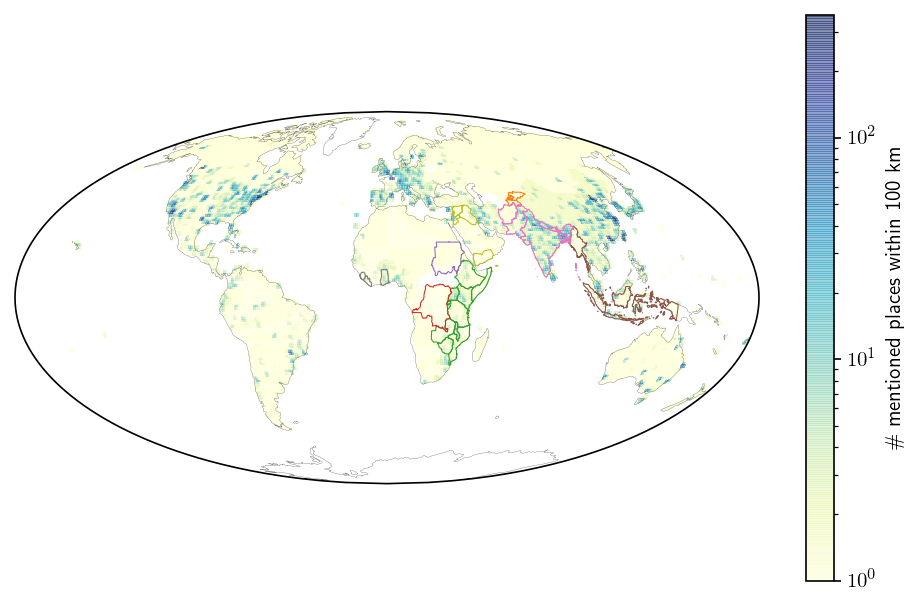

In [25]:

latbins, lonbins, n = density_grid(1,100,df_places)

fig, ax = plt.subplots(dpi=150, figsize=(8,5))
p = ccrs.Mollweide()
#p = ccrs.PlateCarree()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

i = 0
for name, group in country_shapes.groupby("UN statistical"):
    if group["DFID priority"].sum() > 0:
        i+=1
        poly = group.loc[
            (group['DFID priority'] == 1) 
        ]['geometry'].values

        ax.add_geometries(
            poly, 
            crs=ccrs.PlateCarree(), 
            facecolor='none', 
            edgecolor=f'C{i}',
            lw=0.5
        )

        print(name)

cbar = fig.colorbar(pcm)
cbar.set_label("\# mentioned places within 100 km")

In [26]:
df_places.head()

,id,title,content,PY,wc__oecd,wosarticle__di,DOI,admin1,lat,lon,...,Population_2019,Annex I or II,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,3255833,Assessment of spatiotemporal variability of re...,Reference evapotranspiration (ETo) is a key co...,2019.0,NaN,10.1016/j.agwat.2018.09.037,[10.1016/j.agwat.2018.09.037](https://dx.doi.o...,NaN,35.00000,105.00000,...,"1,433,783,686",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
1,3255833,Assessment of spatiotemporal variability of re...,Reference evapotranspiration (ETo) is a key co...,2019.0,NaN,10.1016/j.agwat.2018.09.037,[10.1016/j.agwat.2018.09.037](https://dx.doi.o...,NaN,34.00000,116.00000,...,"1,433,783,686",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
2,3457216,Health-Related Quality of Life of Chinese Eart...,As one of the most destructive natural disaste...,2014.0,NaN,10.1007/s11205-013-0525-2,[10.1007/s11205-013-0525-2](https://dx.doi.org...,Sichuan,30.50000,102.66667,...,"1,433,783,686",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
3,3457216,Health-Related Quality of Life of Chinese Eart...,As one of the most destructive natural disaste...,2014.0,NaN,10.1007/s11205-013-0525-2,[10.1007/s11205-013-0525-2](https://dx.doi.org...,NaN,35.00000,105.00000,...,"1,433,783,686",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN
4,3457216,Health-Related Quality of Life of Chinese Eart...,As one of the most destructive natural disaste...,2014.0,NaN,10.1007/s11205-013-0525-2,[10.1007/s11205-013-0525-2](https://dx.doi.org...,Sichuan,31.34355,104.19588,...,"1,433,783,686",Non-Annex I,NaN,0,Upper-middle,NaN,NaN,NaN,NaN,NaN


calculating density grid of size: 1995
done


<Figure size 1200x1800 with 0 Axes>

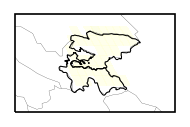

In [27]:
fig = plt.figure(dpi=150,figsize=(8,12))

region_groups = [
    #["Eastern Africa", "Northern Africa","Middle Africa"],
    ["Central Asia"]
]

extents = [
    #[5,55,-30,30],
    [65,80,35,45]
]

fig = plt.figure(dpi=150,figsize=(8,12))

cols = 5
nrows = len(extents)//cols+1

gs = gridspec.GridSpec(nrows*2, cols, height_ratios=[.6, .3]*nrows, bottom=.05, top=.95, wspace=.2, hspace=.25)



for i, (regions, extent) in enumerate(zip(region_groups, extents)):
    
    ax1 = plt.subplot(gs[0, 0], projection=ccrs.Mollweide())

    cs = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]

    sub_df = df_places[df_places["country_predicted"].isin(cs["SOV_A3"])]

    latbins, lonbins, n = density_grid(1,50,sub_df, extent = extent)

    ax1.set_extent(extent)
    ax1.coastlines(lw=0.1)
    ax1.add_feature(cartopy.feature.BORDERS,lw=0.1)
    ax1.add_feature(cartopy.feature.OCEAN)

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )

    poly = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]['geometry'].values

    ax1.add_geometries(
        poly, 
        crs=ccrs.PlateCarree(), 
        facecolor='none', 
        edgecolor='black',
        lw=0.5
    )

In [28]:
dfid_countries = country_shapes.loc[
    (country_shapes['DFID priority'] == 1) 
]
dfid_df = df_places[df_places["country_predicted"].isin(dfid_countries["SOV_A3"])]

latbins, lonbins, n = density_grid(0.5,50,dfid_df, extent = extent)
vm = n[~np.isnan(n)].max()
dfid_df.head()

calculating density grid of size: 8040
done


,id,title,content,PY,wc__oecd,wosarticle__di,DOI,admin1,lat,lon,...,Population_2019,Annex I or II,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
3582,282602,Health coping strategies of the people vulnera...,Background: Among the many challenges faced by...,2013.0,Medical and Health Sciences,10.1186/1471-2458-13-565,[10.1186/1471-2458-13-565](https://dx.doi.org/...,NaN,24.0,90.0,...,"163,046,161",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
3583,2306148,"Exploring the impact, response and preparednes...",Objectives To investigate the impact of natura...,2019.0,NaN,10.1136/bmjopen-2018-026459,[10.1136/bmjopen-2018-026459](https://dx.doi.o...,NaN,24.0,90.0,...,"163,046,161",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
3584,93380,Changes of rainfall extremes around the haor b...,"Haors are large, round-shaped floodplain depre...",2015.0,Natural Sciences,10.1007/s00704-014-1101-7,[10.1007/s00704-014-1101-7](https://dx.doi.org...,NaN,24.0,90.0,...,"163,046,161",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
3585,565908,Tracking Cholera through Surveillance of Oral ...,"Background In Bangladesh, pharmacy-purchased o...",2015.0,Medical and Health Sciences,10.1371/journal.pntd.0004230,[10.1371/journal.pntd.0004230](https://dx.doi....,NaN,24.0,90.0,...,"163,046,161",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
3586,565908,Tracking Cholera through Surveillance of Oral ...,"Background In Bangladesh, pharmacy-purchased o...",2015.0,Medical and Health Sciences,10.1371/journal.pntd.0004230,[10.1371/journal.pntd.0004230](https://dx.doi....,NaN,24.0,90.0,...,"163,046,161",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN


In [29]:
print(sub_df.shape)

(8, 39)


In [30]:
country_shapes.to_csv('../dash-dfid/data/country_shapes.csv',index=False)

calculating density grid of size: 8720
done
calculating density grid of size: 23800
done
calculating density grid of size: 15480
done
calculating density grid of size: 8040
done
calculating density grid of size: 21120
done
calculating density grid of size: 26180
done


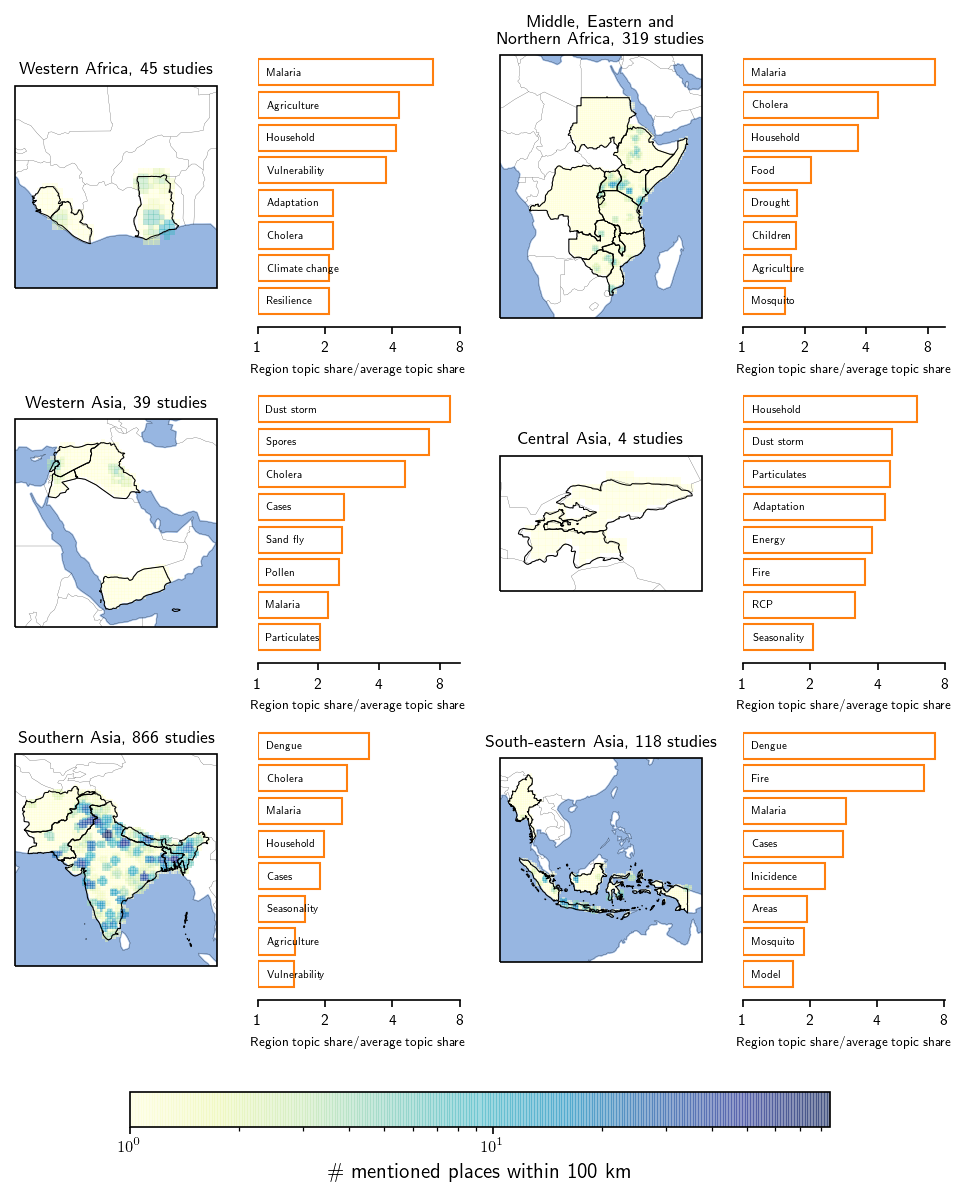

In [31]:
## fig = plt.figure(dpi=150,figsize=(8,12))

region_groups = [
    ["Western Africa"],
    ["Eastern Africa", "Northern Africa","Middle Africa"],
    ["Western Asia"],
    ["Central Asia"],
    ["Southern Asia"],
    ["South-eastern Asia"]

]

labels = [
    "Western Africa",
    "Middle, Eastern and \nNorthern Africa",
    "Western Asia",
    "Central Asia",
    "Southern Asia",
    "South-eastern Asia"
]

extents = [
    [-15,5,0,20],
    [5,55,-30,30],
    [30,60,10,40],
    [66,81,35,45],
    [59,99,3,43],
    [90,145,-20,30]
]

fig = plt.figure(dpi=150,figsize=(8,8))

cols = 2
nrows = len(extents)//cols+1

#gs = gridspec.GridSpec(nrows*2, cols, height_ratios=[.3, .3]*nrows, bottom=.05, top=.95, wspace=.2, hspace=.25)
gs = gridspec.GridSpec(nrows, cols*2, height_ratios=[1]*(nrows-1)+[.25],bottom=.05, top=.95, wspace=.2, hspace=.25)

xlab_positions = [1,2,4,8]
xlabels = [1,2,4,8]


for i, (regions, extent,label) in enumerate(zip(region_groups, extents,labels)):
    
    
    #ax1 = plt.subplot(gs[0, i], projection=ccrs.Mollweide())
    r = i//cols
    c = i%cols*2
    
    ax1 = plt.subplot(gs[r, c], projection=ccrs.PlateCarree())
    cs = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]

    sub_df = df_places[df_places["country_predicted"].isin(cs["SOV_A3"])]

    latbins, lonbins, n = density_grid(0.5,100,sub_df, extent = extent)

    ax1.set_extent(extent)
    ax1.coastlines(lw=0.1)
    ax1.add_feature(cartopy.feature.BORDERS,lw=0.1)
    ax1.add_feature(cartopy.feature.OCEAN)

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )

    poly = country_shapes.loc[
        (country_shapes['DFID priority'] == 1) & 
        (country_shapes['UN statistical'].isin(regions))
    ]['geometry'].values

    ax1.add_geometries(
        poly, 
        crs=ccrs.PlateCarree(), 
        facecolor='none', 
        edgecolor='black',
        lw=0.5
    )
    
    cr = get_group_topics(label,sub_df,dts,8)
    
    ax = plt.subplot(gs[r,c+1])
    l = len(cr["common_topics_scores"])
    
    
    
    ax1.set_title(f'{cr["name"]}, {len(sub_df.id.unique())} studies',fontsize=8)
    #ax.barh(range(l),np.log(cr["uncommon_topics_scores"]))
    ax.barh(
        range(l),np.log(cr["common_topics_scores"]),color="None",
        edgecolor="C1"
    )
    #for j, lab in enumerate(cr["uncommon_topics"]):
        #ax.text(0+pad,j,lab,ha="left", va="center", fontsize=5, usetex=True)
    for j, lab in enumerate(cr["common_topics"]):
        ax.text(0+pad,j, lab, ha="left", va="center", fontsize=5, usetex=True)
    sns.despine(ax=ax,top=True,left=True)
    ax.set_yticks([])
    ax.set_xticks([np.log(lab) for lab in xlab_positions])
    #ax.set_xticks(xlab_positions)
    ax.set_xticklabels(xlabels, fontsize=7, usetex=True)
    ax.set_xlabel("Region topic share/average topic share",fontsize=6)
    
ax = plt.subplot(gs[nrows-1,:])
ax.axis("off")
cbar = fig.colorbar(pcm,ax=ax,orientation="horizontal",fraction=0.5,pad=-1)
cbar.ax.tick_params(labelsize=7)

cbar.set_label("\# mentioned places within 100 km")

In [50]:
for regions, label in zip(region_groups,labels):
    dfid_df.loc[dfid_df["UN statistical"].isin(regions),"DFID region"] = label
    
dfid_df['place_doc_id'] = dfid_df.index
    
dfid_df.drop(columns="content").to_csv('../dash-dfid/data/dfid_df.csv',index=False)
    
gdt = (dfid_df[["doc_id","DFID region"]]
       .merge(dts)
       .groupby(['topic_id','DFID region'])['score']
       .sum()
       .reset_index()
      )
gdt['share'] = gdt['score'] / gdt.groupby('DFID region')['score'].transform('sum')
gdt = gdt.merge(dt_sum)
gdt['deviation'] = gdt['share'] / gdt['total_share']
gdt = (gdt
       .merge(topic_info, left_on="topic_id",right_on="id")
       .sort_values(['DFID region','deviation'])
       .reset_index(drop=True)
      )
gdt['short_title'] = gdt['title'].str.split(',').str[0]
gdt.to_csv('../dash-dfid/data/dfid_topics.csv', index=False)
gdt.head()

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,topic_id,DFID region,score,share,total_score,total_share,deviation,id,title,top_words,short_title
0,212329,Central Asia,0.000104,0.000049,79.708772,0.016272,0.003032,212329,"Death, Excess deaths","['death', 'caus', 'excess', 'year', 'age', 'es...",Death
1,212309,Central Asia,0.000173,0.000082,110.477536,0.022553,0.003620,212309,"Temperature, Ambient temperature","['temperatur', 'degre', 'increas', 'mean', 'am...",Temperature
2,212321,Central Asia,0.000120,0.000057,54.719057,0.011171,0.005084,212321,"Mental, Mental health","['mental', 'health', 'disord', 'physic', 'psyc...",Mental
3,212310,Central Asia,0.000139,0.000066,56.259829,0.011485,0.005730,212310,"Agriculture, Agricultre","['farmer', 'crop', 'agricultur', 'farm', 'prod...",Agriculture
4,212315,Central Asia,0.000316,0.000149,83.040117,0.016952,0.008814,212315,"Inicidence, Disease incidence","['incid', 'rate', 'month', 'per', 'annual', 'y...",Inicidence


In [55]:
dts[dts['doc_id'].isin(dfid_df['doc_id'])].to_csv('../dash-dfid/data/doctopic.csv',index=False)

In [33]:
gdt[gdt['DFID region']=="Western Africa"]

,topic_id,DFID region,score,share,total_score,total_share,deviation,id,title,top_words,short_title
270,212313,Western Africa,0.000522,0.000022,32.514115,0.006638,0.003367,212313,"Stroke, Stroke","['stroke', 'ischem', 'hemorrhag', 'associ', 's...",Stroke
271,212282,Western Africa,0.005179,0.000222,40.077182,0.008182,0.027099,212282,"Pollen, Pollen & airborne allergens","['pollen', 'allergen', 'airborn', 'allergi', '...",Pollen
272,212300,Western Africa,0.008987,0.000385,48.429437,0.009887,0.038914,212300,"Asthma, Asthma","['asthma', 'visit', 'emerg', 'outpati', 'exace...",Asthma
273,212324,Western Africa,0.009751,0.000417,30.044377,0.006133,0.068059,212324,"Spores, Fungal spores","['spore', 'fungal', 'airborn', 'alternaria', '...",Spores
274,212281,Western Africa,0.026653,0.001141,82.009768,0.016742,0.068150,212281,"Emissions, Emission of air pollution","['emiss', 'nox', 'vehicl', 'sourc', 'reduct', ...",Emissions
...,...,...,...,...,...,...,...,...,...,...,...
335,212292,Western Africa,0.737950,0.031590,72.118801,0.014723,2.145635,212292,"Water, Drinking water","['water', 'drink', 'sourc', 'contamin', 'suppl...",Water
336,212307,Western Africa,1.349041,0.057749,75.335923,0.015379,3.754916,212307,"Vulnerability, Vulnerability to climate change","['vulner', 'social', 'hazard', 'indic', 'index...",Vulnerability
337,212310,Western Africa,1.069765,0.045794,56.259829,0.011485,3.987191,212310,"Agriculture, Agricultre","['farmer', 'crop', 'agricultur', 'farm', 'prod...",Agriculture
338,212319,Western Africa,1.343546,0.057513,67.926929,0.013867,4.147513,212319,"Household, Household & houshold fuel use","['household', 'rural', 'stove', 'fuel', 'cook'...",Household


In [34]:
dfid_df.head()

,id,title,content,PY,wc__oecd,wosarticle__di,DOI,admin1,lat,lon,...,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,DFID region,place_doc_id
3582,282602,Health coping strategies of the people vulnera...,Background: Among the many challenges faced by...,2013.0,Medical and Health Sciences,10.1186/1471-2458-13-565,[10.1186/1471-2458-13-565](https://dx.doi.org/...,NaN,24.0,90.0,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3582
3583,2306148,"Exploring the impact, response and preparednes...",Objectives To investigate the impact of natura...,2019.0,NaN,10.1136/bmjopen-2018-026459,[10.1136/bmjopen-2018-026459](https://dx.doi.o...,NaN,24.0,90.0,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3583
3584,93380,Changes of rainfall extremes around the haor b...,"Haors are large, round-shaped floodplain depre...",2015.0,Natural Sciences,10.1007/s00704-014-1101-7,[10.1007/s00704-014-1101-7](https://dx.doi.org...,NaN,24.0,90.0,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3584
3585,565908,Tracking Cholera through Surveillance of Oral ...,"Background In Bangladesh, pharmacy-purchased o...",2015.0,Medical and Health Sciences,10.1371/journal.pntd.0004230,[10.1371/journal.pntd.0004230](https://dx.doi....,NaN,24.0,90.0,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3585
3586,565908,Tracking Cholera through Surveillance of Oral ...,"Background In Bangladesh, pharmacy-purchased o...",2015.0,Medical and Health Sciences,10.1371/journal.pntd.0004230,[10.1371/journal.pntd.0004230](https://dx.doi....,NaN,24.0,90.0,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3586


In [35]:
dfid_df.place_doc_id = dfid_df.index
dfid_df

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,title,content,PY,wc__oecd,wosarticle__di,DOI,admin1,lat,lon,...,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,DFID region,place_doc_id
3582,282602,Health coping strategies of the people vulnera...,Background: Among the many challenges faced by...,2013.0,Medical and Health Sciences,10.1186/1471-2458-13-565,[10.1186/1471-2458-13-565](https://dx.doi.org/...,NaN,24.00000,90.00000,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3582
3583,2306148,"Exploring the impact, response and preparednes...",Objectives To investigate the impact of natura...,2019.0,NaN,10.1136/bmjopen-2018-026459,[10.1136/bmjopen-2018-026459](https://dx.doi.o...,NaN,24.00000,90.00000,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3583
3584,93380,Changes of rainfall extremes around the haor b...,"Haors are large, round-shaped floodplain depre...",2015.0,Natural Sciences,10.1007/s00704-014-1101-7,[10.1007/s00704-014-1101-7](https://dx.doi.org...,NaN,24.00000,90.00000,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3584
3585,565908,Tracking Cholera through Surveillance of Oral ...,"Background In Bangladesh, pharmacy-purchased o...",2015.0,Medical and Health Sciences,10.1371/journal.pntd.0004230,[10.1371/journal.pntd.0004230](https://dx.doi....,NaN,24.00000,90.00000,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3585
3586,565908,Tracking Cholera through Surveillance of Oral ...,"Background In Bangladesh, pharmacy-purchased o...",2015.0,Medical and Health Sciences,10.1371/journal.pntd.0004230,[10.1371/journal.pntd.0004230](https://dx.doi....,NaN,24.00000,90.00000,...,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN,Southern Asia,3586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16577,3455121,"Aeropalynological spectrum of Hatay, Turkey, t...",An aeropalynological study during the years 20...,2018.0,NaN,10.1007/s10453-018-9531-9,[10.1007/s10453-018-9531-9](https://dx.doi.org...,NaN,35.00000,38.00000,...,NaN,1,Low,NaN,NaN,NaN,NaN,NaN,Western Asia,16577
16578,3475632,Plasmodium vivax associated severe malaria com...,"Background: Although, Plasmodium vivax is a ra...",2013.0,NaN,10.1186/1471-2458-13-637,[10.1186/1471-2458-13-637](https://dx.doi.org/...,Aleppo,36.20124,37.16117,...,NaN,1,Low,NaN,NaN,NaN,NaN,NaN,Western Asia,16578
16719,1253489,Re-emerging Lassa fever outbreaks in Nigeria: ...,We evaluated the impact of man-made conflict e...,2018.0,Medical and Health Sciences,10.1186/s40249-018-0421-8,[10.1186/s40249-018-0421-8](https://dx.doi.org...,NaN,8.50000,-11.50000,...,NaN,1,Low,NaN,NaN,NaN,NaN,NaN,Western Africa,16719
16812,774522,Lessons Learned on Health Adaptation to Climat...,BACKGROUND: There is limited published evidenc...,2017.0,Natural Sciences,10.1289/EHP405,[10.1289/EHP405](https://dx.doi.org/10.1289/EH...,NaN,39.00000,71.00000,...,NaN,1,Low,NaN,NaN,NaN,NaN,NaN,Central Asia,16812


In [36]:
dfid_countries

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,Population_2019,Annex I or II,SIDS,DFID priority,Income,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,"14,645,468",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,"17,861,030",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,"29,161,922",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
29,Admin-0 country,1,3,Uganda,UGA,0,2,Sovereign country,Uganda,UGA,...,"44,269,594",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
38,Admin-0 country,3,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,"58,005,463",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
39,Admin-0 country,1,4,Tajikistan,TJK,0,2,Sovereign country,Tajikistan,TJK,...,"9,321,018",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
41,Admin-0 country,1,3,Syria,SYR,0,2,Sovereign country,Syria,SYR,...,"17,070,135",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
46,Admin-0 country,1,3,Sudan,SDN,0,2,Sovereign country,Sudan,SDN,...,"42,813,238",Non-Annex I,NaN,1,Lower-middle,NaN,NaN,NaN,NaN,NaN
51,Admin-0 country,1,6,Somalia,SOM,0,2,Sovereign country,Somalia,SOM,...,"15,442,905",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN
56,Admin-0 country,1,4,Sierra Leone,SLE,0,2,Sovereign country,Sierra Leone,SLE,...,"7,813,215",Non-Annex I,NaN,1,Low,NaN,NaN,NaN,NaN,NaN


In [38]:
country

<Record: <shapely.geometry.polygon.Polygon object at 0x7fef797b5a58>, {'featurecla': 'Admin-0 country', 'scalerank': 1, 'LABELRANK': 3, 'SOVEREIGNT': 'Zimbabwe', 'SOV_A3': 'ZWE', 'ADM0_DIF': 0, 'LEVEL': 2, 'TYPE': 'Sovereign country', 'ADMIN': 'Zimbabwe', 'ADM0_A3': 'ZWE', 'GEOU_DIF': 0, 'GEOUNIT': 'Zimbabwe', 'GU_A3': 'ZWE', 'SU_DIF': 0, 'SUBUNIT': 'Zimbabwe', 'SU_A3': 'ZWE', 'BRK_DIFF': 0, 'NAME': 'Zimbabwe', 'NAME_LONG': 'Zimbabwe', 'BRK_A3': 'ZWE', 'BRK_NAME': 'Zimbabwe', 'BRK_GROUP': None, 'ABBREV': 'Zimb.', 'POSTAL': 'ZW', 'FORMAL_EN': 'Republic of Zimbabwe', 'FORMAL_FR': None, 'NAME_CIAWF': 'Zimbabwe', 'NOTE_ADM0': None, 'NOTE_BRK': None, 'NAME_SORT': 'Zimbabwe', 'NAME_ALT': None, 'MAPCOLOR7': 1, 'MAPCOLOR8': 5, 'MAPCOLOR9': 3, 'MAPCOLOR13': 9, 'POP_EST': 13805084, 'POP_RANK': 14, 'GDP_MD_EST': 28330.0, 'POP_YEAR': 2017, 'LASTCENSUS': 2002, 'GDP_YEAR': 2016, 'ECONOMY': '5. Emerging region: G20', 'INCOME_GRP': '5. Low income', 'WIKIPEDIA': -99, 'FIPS_10_': 'ZI', 'ISO_A2': 'ZW', '

In [39]:
country_shapes.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3',
       ...
       'Population_2019', 'Annex I or II', 'SIDS', 'DFID priority', 'Income',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18'],
      dtype='object', length=114)

In [49]:
geojson = country_shapes[["geometry","SOV_A3","DFID priority"]].rename(columns={"SOV_A3": "id"})
geojson[geojson['DFID priority']==1].to_file('../dash-dfid/data/dfid.geojson', driver='GeoJSON')

In [41]:
country_shapes[["SOV_A3","DFID priority",'UN statistical']].to_csv('../dash-dfid/data/country_shapes.csv', index=False)

In [32]:
df_places.to_csv('data/df_places.csv',index=False)